In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [9]:
x=np.arange(0,12).reshape(3,4)
y=np.array([True,False,True])
print(y)
print(x)
x[y,1]

[ True False  True]
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


array([1, 9])

In [2]:
#x是特征，y是标签
x, y = datasets.make_moons(n_samples=50000, noise=0.3, random_state=42)
print(x.shape)
print(y.shape)
print(np.unique(y))

(50000, 2)
(50000,)
[0 1]


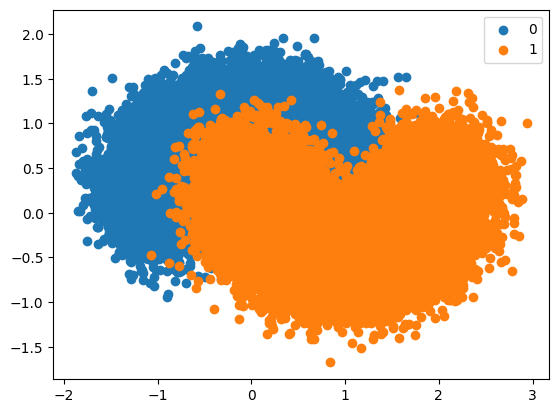

In [4]:

plt.scatter(x[y == 0, 0], x[y == 0, 1])  #拿到特征中标签为0的第0列，拿到标签为0的第一列
plt.scatter(x[y == 1, 0], x[y == 1, 1]) #拿到特征中标签为1的第0列，拿到标签为1的第一列
plt.legend(['0', '1'])
plt.show()  #图形的点颜色是自动的

In [ ]:
# x[y == 0, 0]

In [5]:
x[0:10]

array([[ 0.71820567, -0.21809028],
       [ 0.11096372,  1.10964541],
       [ 0.61562814, -0.06539887],
       [ 0.46175947,  1.17926518],
       [ 1.22553968, -0.51211163],
       [ 1.27989488,  0.19395679],
       [ 0.51249388,  1.21727796],
       [ 1.97017831,  0.3277893 ],
       [ 0.63961463,  0.9269041 ],
       [ 0.38809941, -0.32770396]])

In [7]:
np.unique(y)

array([0, 1], dtype=int64)

In [8]:
#默认分割比例是75%和25%
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [9]:
from sklearn.linear_model import LogisticRegression
#逻辑回归是搞分类的
log_clf = LogisticRegression()
log_clf.fit(x_train, y_train)
log_clf.score(x_test, y_test)

0.85344

In [10]:
from sklearn.svm import SVC

svm_clf = SVC() #支持向量机
svm_clf.fit(x_train, y_train)
svm_clf.score(x_test, y_test)

0.91216

In [11]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train)
dt_clf.score(x_test, y_test)

0.87504

# 1 手动实现投票分类器

In [12]:
#训练好模型，测试集做预测
y_predict1 = log_clf.predict(x_test)
y_predict2 = svm_clf.predict(x_test)
y_predict3 = dt_clf.predict(x_test)

In [13]:
#bagging，纯手动bagging
y_predict = np.array((y_predict1 + y_predict2 + y_predict3) >= 2, dtype='int')
y_predict[:10]

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1])

In [10]:
y_test[:10]

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

In [14]:
from sklearn.metrics import accuracy_score

#accuracy_score计算准确率的
accuracy_score(y_test, y_predict)

0.904

# 2 集成学习VotingClassifier(并行)

In [15]:
from sklearn.ensemble import VotingClassifier

#hard模式就是少数服从多数
voting_clf = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC()),
    ('dt_clf', DecisionTreeClassifier())], voting='hard')

In [16]:
voting_clf.fit(x_train, y_train)
voting_clf.score(x_test, y_test)

0.90472

更合理的投票，应该有权值
唱歌比赛的投票?(评委的投票权重与观众不一样)

In [17]:
# hard和soft区别请看课件解释,训练时间久
voting_clf2 = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC(probability=True)),  #支持向量机中需要加入probability
    ('dt_clf', DecisionTreeClassifier())], voting='soft')
voting_clf2.fit(x_train, y_train)
voting_clf2.score(x_test, y_test)


0.9044

使用bagging

In [16]:
50000*0.75

37500.0

In [18]:
from sklearn.tree import DecisionTreeClassifier  #用决策树集成上千模型
from sklearn.ensemble import BaggingClassifier

#估计器数目是5000呢？bootstrap是有放回抽样,max_samples不可以超过训练集的数目37500
bagging_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=300,
                                max_samples=3000, bootstrap=True)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

0.9124

# 3 oob设计

In [19]:
from sklearn.tree import DecisionTreeClassifier  #用决策树集成上千模型
from sklearn.ensemble import BaggingClassifier
#当去做有放回的抽样时，把没有取到的样本作为验证集，可以用oob_score来评估
bagging_clf2 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=1000,
                                 bootstrap=True,
                                 oob_score=True)
bagging_clf2.fit(x_train, y_train)
bagging_clf2.oob_score_  #拿没有取到的样本作为验证集

0.9154666666666667

In [20]:
bagging_clf2.score(x_test, y_test)

0.91288

### njobs

In [3]:
from sklearn.tree import DecisionTreeClassifier  #用决策树集成上千模型
from sklearn.ensemble import BaggingClassifier

In [21]:
%%time
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=500, max_samples=2000,
                                bootstrap=True)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)
#cpu time是实际cpu运行算法时间，wall time是墙上真实时间，就是real time（包含了进程启动时间，I/O等待时间等）

CPU times: total: 5 s
Wall time: 5.15 s


0.91176

In [22]:
%%time
#多核使用的时间更小, %%time要顶格来写
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=500, max_samples=2000,
                                bootstrap=True, n_jobs=-1)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

CPU times: total: 406 ms
Wall time: 4.5 s


0.91192

# 4 bootstrap_features  对特征进行采样

In [23]:
#因为我们就两个特征，所以max_features设置为1,得到的分值较低是因为我们特征较少，采用随机特征不合适
#这个是只对特征进行采样
random_subspaces_clf = BaggingClassifier(DecisionTreeClassifier(),
                                         n_estimators=500, max_samples=500, oob_score=True,
                                         bootstrap=True, n_jobs=-1,
                                         max_features=1, bootstrap_features=True)
random_subspaces_clf.fit(x, y)
random_subspaces_clf.oob_score_

0.88618

In [25]:
# 这里是为了验证总的抽样的样本数不能大于训练集的数目
random_patches_clf = BaggingClassifier(DecisionTreeClassifier(),
                                       n_estimators=500, max_samples=50001, oob_score=True,
                                       bootstrap=True, n_jobs=-1,
                                       max_features=1, bootstrap_features=True)
random_patches_clf.fit(x, y)
random_patches_clf.oob_score_
#这个代码有另外一个名字就是随机森林

ValueError: max_samples must be <= n_samples

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
%%time

rc_clf = RandomForestClassifier(n_estimators=500, random_state=666,
                                oob_score=True, n_jobs=-1)
rc_clf.fit(x, y)
rc_clf.oob_score_

CPU times: total: 1min 14s
Wall time: 13.9 s


0.90322

In [41]:
%%time
rc_clf = RandomForestClassifier(max_samples=37500, n_jobs=-1)
rc_clf.fit(x_train, y_train)
rc_clf.score(x_test, y_test)

CPU times: total: 8.03 s
Wall time: 1.53 s


0.90296

In [29]:
%%time
#max_leaf_nodes 最大的叶子结点数
rc_clf2 = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 random_state=666,
                                 oob_score=True, n_jobs=-1)
rc_clf2.fit(x, y)
rc_clf2.oob_score_

CPU times: total: 36.8 s
Wall time: 7.55 s


0.90962

# 5 Extra-Trees
ExtraTreesClassifier 是一种机器学习算法，属于基于决策树的集成方法家族。
它随机选择特征子集和数据样本来构建多个决策树，并将它们的预测聚合起来做出最终预测。
它可用于分类任务，并以处理嘈杂和高维数据的能力而闻名。

In [30]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(n_estimators=500, oob_score=True,
                              bootstrap=True, n_jobs=-1)
et_clf.fit(x, y)
et_clf.oob_score_

0.90624

# Boosting

# 5 串行（包含adaboost和GBDT）

In [32]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [34]:
%%time
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(),algorithm='SAMME',
                             n_estimators=500)
ada_clf.fit(x_train, y_train)
ada_clf.score(x_test, y_test)


CPU times: total: 219 ms
Wall time: 222 ms


0.876

In [35]:
#它默认用的也是决策树，增加了基分类器的数目后，准确率提升
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(max_depth=3, n_estimators=500)
gb_clf.fit(x_train, y_train)
gb_clf.score(x_test, y_test)

0.91192

In [3]:
import numpy as np

print(np.log(9))  #当错误率是0.1时权重是2.19
np.log((1-0.5)/0.5)  #当错误率是0.5时，权重是0

2.1972245773362196


0.0